# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV434"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 200
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv434')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv434/lv434-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 22:41:47,138 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP055569, SRP066834, SRP057196, SRP042161, SRP033135, SRP024268, SRP059775, SRP022892, SRP007947, SRP060416, SRP063840, SRP007498, SRP006474, SRP017959, SRP010350, SRP006970, SRP064464, SRP010279, SRP043166, SRP041751, SRP030617, SRP050499, SRP055153, SRP010129, SRP058773, SRP025989, SRP018717, SRP050992, SRP010038, SRP042228, SRP037722, SRP015853, SRP041825, SRP045859, SRP009862, SRP044917, SRP012546, SRP012461, SRP014670, SRP064323, SRP018838, SRP018242, SRP003726, SRP009266, SRP050892, SRP025982, SRP014620, SRP067214, SRP059035, SRP050087, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (48 != 50)
  warnings.warn(


In [19]:
lv_data.shape

(8640, 81)

In [20]:
lv_data.head()

cell type Stage tissue  age  \
project   run                                                              
SRP055569 SRR1821717  MCF10a human breast cancer cells   NaN    NaN  NaN   
          SRR1821716  MCF10a human breast cancer cells   NaN    NaN  NaN   
          SRR1821715  MCF10a human breast cancer cells   NaN    NaN  NaN   
          SRR1821714  MCF10a human breast cancer cells   NaN    NaN  NaN   
          SRR1821713  MCF10a human breast cancer cells   NaN    NaN  NaN   

                     c1 chip id experiment_sample_name cell line patient id  \
project   run                                                                 
SRP055569 SRR1821717        NaN                    NaN       NaN        NaN   
          SRR1821716        NaN                    NaN       NaN        NaN   
          SRR1821715        NaN                    NaN       NaN        NaN   
          SRR1821714        NaN                    NaN       NaN        NaN   
          SRR1821713        NaN                    NaN       NaN        NaN   

                     subtype hour post serum-switch  ... site library id lane  \
project   run                                        ...                        
SRP055569 SRR1821717     NaN                    NaN  ...  NaN        NaN  NaN   
          SRR1821716     NaN                    NaN  ...  NaN        NaN  NaN   
          SRR1821715     NaN                    NaN  ...  NaN        NaN  NaN   
          SRR1821714     NaN                    NaN  ...  NaN        NaN  NaN   
          SRR1821713     NaN                    NaN  ...  NaN        NaN  NaN   

                     flowcell antibody used for sorting tissue source  \
project   run                                                           
SRP055569 SRR1821717      NaN                       NaN           NaN   
          SRR1821716      NaN                       NaN           NaN   
          SRR1821715      NaN                       NaN           NaN   
          SRR1821714      NaN                       NaN           NaN   
          SRR1821713      NaN                       NaN           NaN   

                     sample description experiment group sequenced molecule  \
project   run                                                                 
SRP055569 SRR1821717                NaN              NaN                NaN   
          SRR1821716                NaN              NaN                NaN   
          SRR1821715                NaN              NaN                NaN   
          SRR1821714                NaN              NaN                NaN   
          SRR1821713                NaN              NaN                NaN   

                         LV434  
project   run                   
SRP055569 SRR1821717  0.052303  
          SRR1821716 -0.079737  
          SRR1821715  0.163664  
          SRR1821714  0.281569  
          SRR1821713  0.106651  

[5 rows x 81 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

culture medium                    0.025531
cell type                         0.015845
tnm                               0.014552
antibody                          0.006593
age                               0.004058
c1 chip id                        0.003620
experiment_sample_name            0.003620
antibody catalog #                0.003571
cell source                       0.003340
well number                       0.003125
reprogramming time point (day)    0.003125
race                              0.003083
Stage                             0.003046
cancer or normal                  0.002976
tissue                            0.002715
enzymatic digestion               0.002514
protein                           0.002514
clip variant                      0.002514
antibody manufacturer             0.002436
gender                            0.002357
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.015845
tissue       0.002715
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "cell line",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type  \
project   run                                                             
SRP055569 SRR1821674                   MCF10a human breast cancer cells   
          SRR1821642                   MCF10a human breast cancer cells   
          SRR1821680                   MCF10a human breast cancer cells   
SRP066834 SRR2967492                                                NaN   
SRP055569 SRR1821382                             U87 human glioma cells   
          SRR1821530  mixture of U87 human glioma cells and MCF10a h...   
SRP057196 SRR1974896                                  fetal_replicating   
SRP055569 SRR1821602  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821511  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821374                             U87 human glioma cells   
          SRR2019033                             U87 human glioma cells   
          SRR1821710                   MCF10a human breast cancer cells   
SRP042161 SRR1294611                                       Glioblastoma   
SRP055569 SRR1821470  mixture of U87 human glioma cells and MCF10a h...   
SRP033135 SRR1033244             Human Skeletal Muscle Myoblasts (HSMM)   
SRP055569 SRR1821464  mixture of U87 human glioma cells and MCF10a h...   
SRP024268 SRR886378                                                 NaN   
SRP055569 SRR1821461  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821624                   MCF10a human breast cancer cells   
SRP059775 SRR2074919                                                NaN   
SRP022892 SRR857933                                                 NaN   
SRP055569 SRR2018988                   MCF10a human breast cancer cells   
          SRR1821633                   MCF10a human breast cancer cells   
          SRR1821476  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821659                   MCF10a human breast cancer cells   

                                                                 tissue  \
project   run                                                             
SRP055569 SRR1821674                                                NaN   
          SRR1821642                                                NaN   
          SRR1821680                                                NaN   
SRP066834 SRR2967492  Microdissected cortical-like ventricle from ce...   
SRP055569 SRR1821382                                                NaN   
          SRR1821530                                                NaN   
SRP057196 SRR1974896                                             cortex   
SRP055569 SRR1821602                                                NaN   
          SRR1821511                                                NaN   
          SRR1821374                                                NaN   
          SRR2019033                                                NaN   
          SRR1821710                                                NaN   
SRP042161 SRR1294611                                                NaN   
SRP055569 SRR1821470                                                NaN   
SRP033135 SRR1033244                                                NaN   
SRP055569 SRR1821464                                                NaN   
SRP024268 SRR886378                                        renal pelvis   
SRP055569 SRR1821461                                                NaN   
          SRR1821624                                                NaN   
SRP059775 SRR2074919                                                NaN   
SRP022892 SRR857933                                                 NaN   
SRP055569 SRR2018988                                                NaN   
          SRR1821633                                                NaN   
          SRR1821476                                                NaN   
          SRR1821659                                                NaN   

          

In [26]:
# what is there in these projects?
lv_data.loc[["SRP059775", "SRP022892"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

cell line antibody culture medium     LV434
project   run                                                          
SRP059775 SRR2074919  HEK and 3T3 mix      NaN            NaN  0.406059
SRP022892 SRR857933            HEK293     FLAG           DMEM  0.398570
SRP059775 SRR2074920  HEK and 3T3 mix      NaN            NaN  0.239659
          SRR2074918  HEK and 3T3 mix      NaN            NaN  0.056741
          SRR2074823  HEK and 3T3 mix      NaN            NaN  0.052769
          SRR2074767  HEK and 3T3 mix      NaN            NaN  0.046659
          SRR2074853  HEK and 3T3 mix      NaN            NaN  0.046613
SRP022892 SRR857934            HEK293     FLAG           DMEM  0.044777
SRP059775 SRR2074780  HEK and 3T3 mix      NaN            NaN  0.043345
          SRR2074850  HEK and 3T3 mix      NaN            NaN  0.042145

**HEK** are kidney cells, and **3T3** are embryonic fibroblasts.

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "cell line"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP055569 SRR1821674                   MCF10a human breast cancer cells   
          SRR1821642                   MCF10a human breast cancer cells   
          SRR1821680                   MCF10a human breast cancer cells   
SRP066834 SRR2967492  Microdissected cortical-like ventricle from ce...   
SRP055569 SRR1821382                             U87 human glioma cells   
          SRR1821530  mixture of U87 human glioma cells and MCF10a h...   
SRP057196 SRR1974896                                  fetal_replicating   
SRP055569 SRR1821602  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821511  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821374                             U87 human glioma cells   
          SRR2019033                             U87 human glioma cells   
          SRR1821710                   MCF10a human breast cancer cells   
SRP042161 SRR1294611                                       Glioblastoma   
SRP055569 SRR1821470  mixture of U87 human glioma cells and MCF10a h...   
SRP033135 SRR1033244             Human Skeletal Muscle Myoblasts (HSMM)   
SRP055569 SRR1821464  mixture of U87 human glioma cells and MCF10a h...   
SRP024268 SRR886378                                        renal pelvis   
SRP055569 SRR1821461  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821624                   MCF10a human breast cancer cells   
SRP059775 SRR2074919                                    HEK and 3T3 mix   

                         LV434  
project   run                   
SRP055569 SRR1821674  6.337569  
          SRR1821642  3.498340  
          SRR1821680  1.673847  
SRP066834 SRR2967492  0.868404  
SRP055569 SRR1821382  0.755420  
          SRR1821530  0.729293  
SRP057196 SRR1974896  0.669457  
SRP055569 SRR1821602  0.637583  
          SRR1821511  0.508077  
          SRR1821374  0.463940  
          SRR2019033  0.459844  
          SRR1821710  0.442061  
SRP042161 SRR1294611  0.441076  
SRP055569 SRR1821470  0.430237  
SRP033135 SRR1033244  0.428080  
SRP055569 SRR1821464  0.426267  
SRP024268 SRR886378   0.423698  
SRP055569 SRR1821461  0.422648  
          SRR1821624  0.419157  
SRP059775 SRR2074919  0.406059

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # SRP057196
            "fetal_replicating": "Fetal neurons (replicating)",
            "fetal_quiescent": "Fetal neurons (quiescent)",
            # SRP006970
            "glioblastoma": "Glioblastoma",
            # SRP055569
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

In [34]:
# all samples from SRP057196 are from brain
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: f"{x['cell type']} (brain)"
    if x.name[0] == "SRP057196"
    else x["cell type"],
    axis=1,
)

In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['MCF10a human breast cancer cells',
 'Microdissected cortical-like ventricle from cerebral organoid',
 'U87 human glioma cells',
 'Glioma cells + breast cancer cells',
 'Fetal neurons (replicating) (brain)']

## Plot

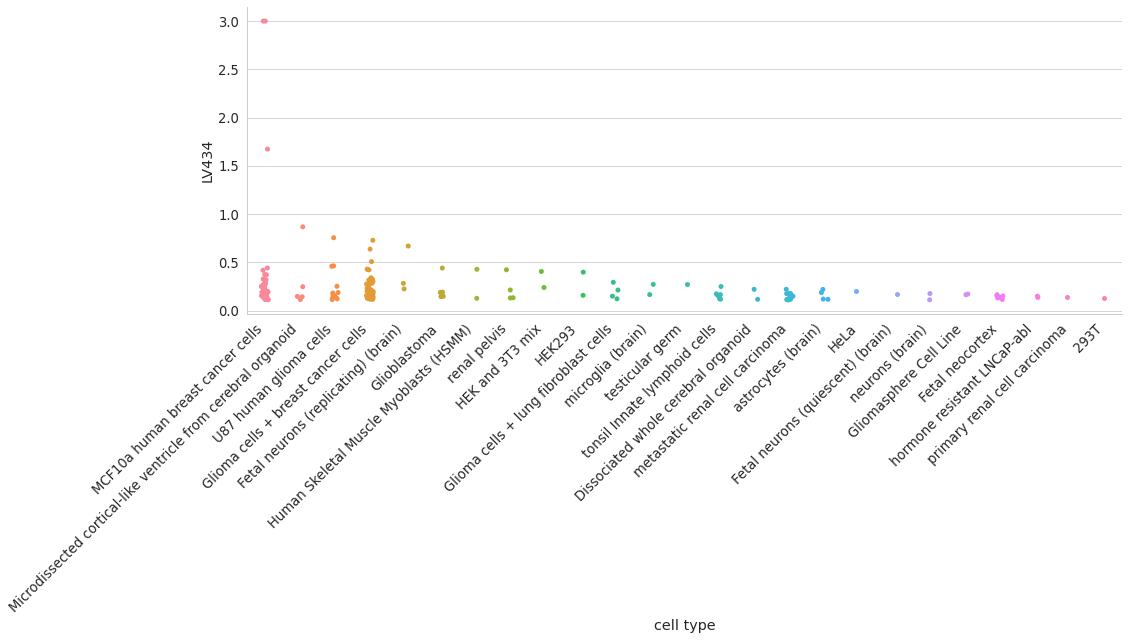

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("293T")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP010279"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)